In [1]:
import os
import pandas as pd 
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import shap

os.chdir('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')
outdir = 'results/aggregated/rf_model/'
datadir = 'results/aggregated/comp_data/'

# set the random_state
random_state = 17

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the protein levels data
fn = os.path.join(datadir, "protein_levels.npq.tsv")
protein_data = pd.read_csv(fn, sep="\t")
protein_data = protein_data.T

# Load the clinical data
fn = os.path.join(datadir, "clinical_data.tsv")
clinical_data = pd.read_csv(fn, sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

In [3]:
protein_data.iloc[0:10]

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
1,5.493463,8.765074,15.762125,11.250206,17.797539,14.680759,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.941009,0.000000,18.239541,16.684025,9.214276,22.586944,14.758306,7.103437,8.497241
3,5.583930,10.499718,16.954187,12.154651,16.987400,14.880401,4.624407,9.629794,11.962107,8.877860,...,3.221491,11.451966,3.547053,17.965469,18.726331,8.410928,20.470995,17.123810,7.301781,8.482880
4,8.194804,11.190956,16.759397,14.787966,19.749733,15.769965,0.000000,9.874354,13.901234,10.912226,...,8.954067,11.554321,7.338846,19.080495,18.295497,10.007122,21.643627,19.786150,7.407648,7.753458
5,6.063246,9.749962,19.285812,13.160575,19.752169,15.816694,0.000000,10.177017,14.180465,11.117418,...,8.001155,11.222148,4.959515,19.051061,18.641904,10.107383,21.672241,17.976551,8.553311,9.922774
6,2.699240,7.201741,17.125303,11.253613,18.437835,12.826293,0.000000,8.075809,10.337083,3.689108,...,4.560512,11.282615,3.150136,18.001517,17.407476,7.969879,20.993046,14.225735,2.344301,7.317010
7,6.469100,11.617355,17.495716,12.059989,20.113406,12.856197,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.470729,0.000000,18.526758,18.228802,7.187657,20.129071,17.565488,5.531130,5.503245
8,5.507946,8.958267,15.013518,12.517046,19.478110,15.515226,0.000000,8.231310,11.611285,8.822733,...,5.400089,11.491307,8.501867,18.289027,17.332893,9.432175,21.837866,15.847341,6.118020,7.880839
9,3.547912,9.236556,16.140030,12.396512,18.840230,16.420197,0.000000,8.256038,11.376874,8.844315,...,3.328541,11.419034,1.897785,19.035433,17.570236,8.732655,23.134103,13.773584,5.945930,6.477688
10,0.000000,10.760127,14.501868,11.910717,17.911680,16.366152,0.000000,11.076341,10.728375,6.797061,...,7.488108,12.442397,0.000000,18.767754,19.159038,7.197030,22.018265,18.689473,8.541784,6.503027
11,6.089471,10.918441,17.668777,11.830969,19.906053,15.877859,0.000000,8.267880,10.499431,11.346562,...,7.218857,11.171852,9.504251,19.783576,18.075417,10.338195,21.960302,16.802203,7.412990,9.246404


## Predicting IBD Diagnosis

In [4]:
# Extract the diagnosis column
task_data = clinical_data['ibd_diagnosis']

In [5]:
# resample to balance classes
X_resampled, task_resampled = RandomOverSampler(random_state=random_state).fit_resample(protein_data, task_data)

In [6]:
# X_train, y_train = protein_data, diagnosis
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, task_resampled, test_size=0.2, random_state=random_state)

model = RandomForestClassifier(random_state=0)

In [7]:
# Fit the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [8]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 1.00


In [9]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 0.91


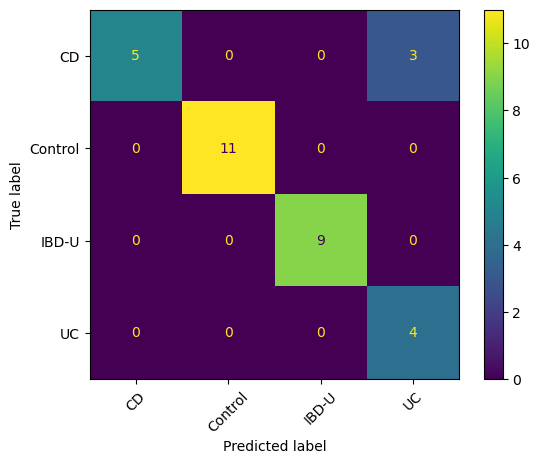

In [11]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'rf_model.ibd_diagnosis.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [12]:
# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          CD       1.00      0.62      0.77         8
     Control       1.00      1.00      1.00        11
       IBD-U       1.00      1.00      1.00         9
          UC       0.57      1.00      0.73         4

    accuracy                           0.91        32
   macro avg       0.89      0.91      0.87        32
weighted avg       0.95      0.91      0.91        32



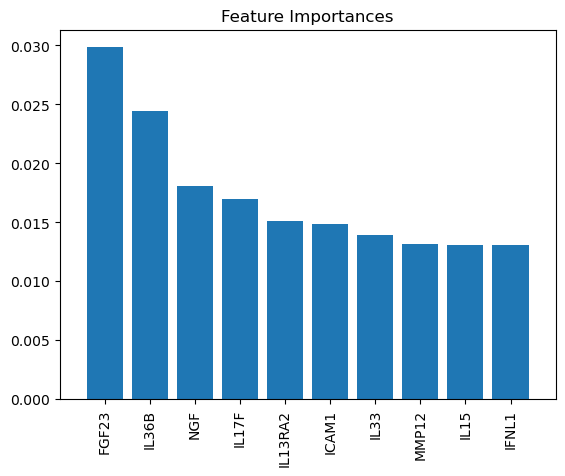

In [13]:
# get importance scores
importances = model.feature_importances_

# get data
topn = 10
indices = np.argsort(importances)[::-1][0:topn]
feature_names = protein_data.columns

# plot
fig, ax = plt.subplots()
ax.set_title("Feature Importances")
ax.bar(range(topn), importances[indices], align="center")
ax.set_xticks(range(topn), np.array(feature_names)[indices], rotation=90)
ax.set_xlim([-1, topn])

fn = os.path.join(outdir, 'rf_model.ibd_diagnosis.feature_importance.png')
fig.savefig(fn, dpi=600)

In [14]:
importances_df = pd.DataFrame([importances, feature_names]).T
importances_df.columns = ['score', 'protein']
importances_df = importances_df[['protein', 'score']]

In [15]:
outfn = os.path.join(outdir, 'rf_model.disease_activity.scores.tsv')
importances_df.to_csv(outfn, index=None, sep="\t")

In [16]:
importances_df.head()

,protein,score
0,AGER,0.003423
1,AGRP,0.003887
2,ANGPT1,0.0
3,ANGPT2,0.001964
4,ANXA1,0.004192


## Predicting Disease Activity

In [17]:
# Extract the diagnosis column
task_data = clinical_data['disease_activity']

In [18]:
# resample to balance classes
X_resampled, task_resampled = RandomOverSampler(random_state=random_state).fit_resample(protein_data, task_data)

In [19]:
task_resampled.value_counts()

disease_activity
Quiescent                42
Mild                     42
Moderate                 42
N/A (Non-IBD Control)    42
Name: count, dtype: int64

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, task_resampled, test_size=0.2, random_state=random_state)
model = RandomForestClassifier(random_state=0)

In [21]:
# Fit the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [22]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 1.00


In [23]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 1.00


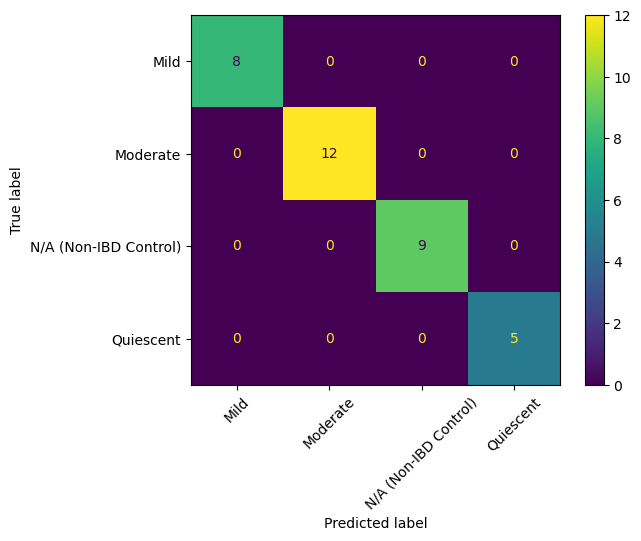

In [24]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'rf_model.disease_activity.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [25]:
# Print the classification report
print(classification_report(y_test, predictions))

                       precision    recall  f1-score   support

                 Mild       1.00      1.00      1.00         8
             Moderate       1.00      1.00      1.00        12
N/A (Non-IBD Control)       1.00      1.00      1.00         9
            Quiescent       1.00      1.00      1.00         5

             accuracy                           1.00        34
            macro avg       1.00      1.00      1.00        34
         weighted avg       1.00      1.00      1.00        34



In [26]:
# get importance scores
importances = model.feature_importances_
feature_names = model.feature_names_in_

# get data
topn = 10
indices = np.argsort(importances)[::-1][0:topn]
feature_names = protein_data.columns

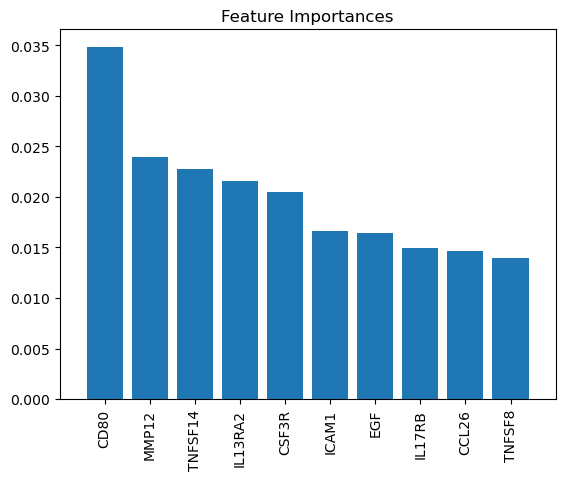

In [27]:
# plot
fig, ax = plt.subplots()
ax.set_title("Feature Importances")
ax.bar(range(topn), importances[indices], align="center")
ax.set_xticks(range(topn), np.array(feature_names)[indices], rotation=90)
ax.set_xlim([-1, topn])

fn = os.path.join(outdir, 'rf_model.disease_activity.feature_importance.png')
fig.savefig(fn, dpi=600)

In [28]:
importances_df = pd.DataFrame([importances, feature_names]).T
importances_df.columns = ['score', 'protein']
importances_df = importances_df[['protein', 'score']]

In [29]:
outfn = os.path.join(outdir, 'rf_model.disease_activity.scores.tsv')
importances_df.to_csv(outfn, index=None, sep="\t")

In [30]:
importances_df.head(20)

,protein,score
0,AGER,0.002643
1,AGRP,0.000662
2,ANGPT1,0.002305
3,ANGPT2,0.012548
4,ANXA1,0.004744
5,AREG,0.00047
6,BDNF,0.0
7,BMP7,0.001455
8,BST2,0.003038
9,C1QA,0.000783


## Use shap values to understand each class

In [31]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

In [32]:
# # compute SHAP values
# shap_values = explainer.shap_values(X_test)

# compute SHAP values
shap_values = explainer(X_test)

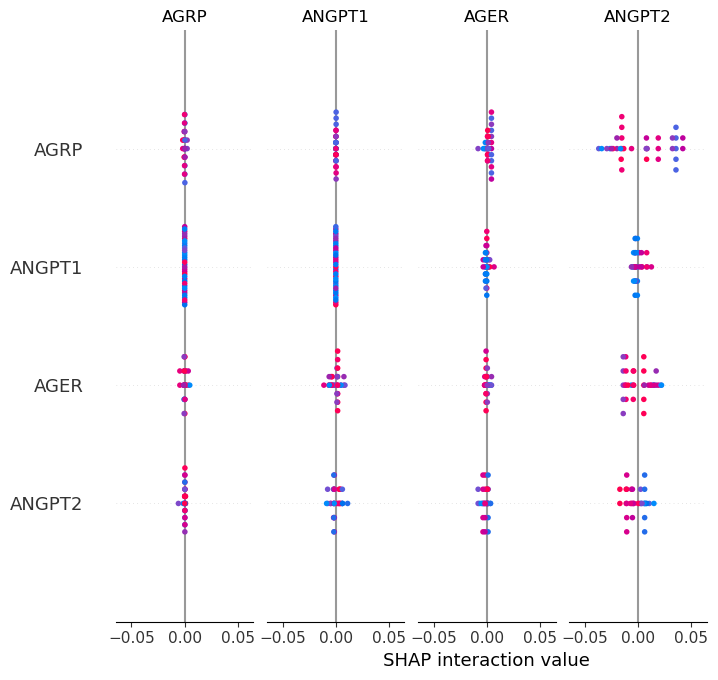

In [33]:
class_names = y_test.unique().tolist()
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names= class_names, feature_names = X_test.columns)

In [34]:
# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

In [35]:
# Check the shape of SHAP values
print(f"Shape of shap_values: {shap_values.shape}")

Shape of shap_values: (34, 250, 4)


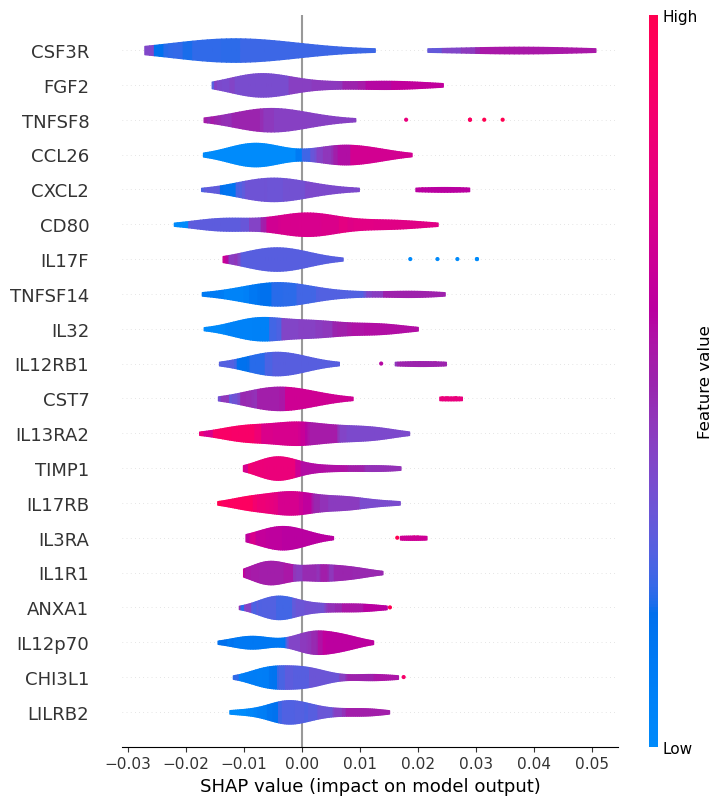

In [36]:
shap.plots.violin(shap_values[:,:,0])

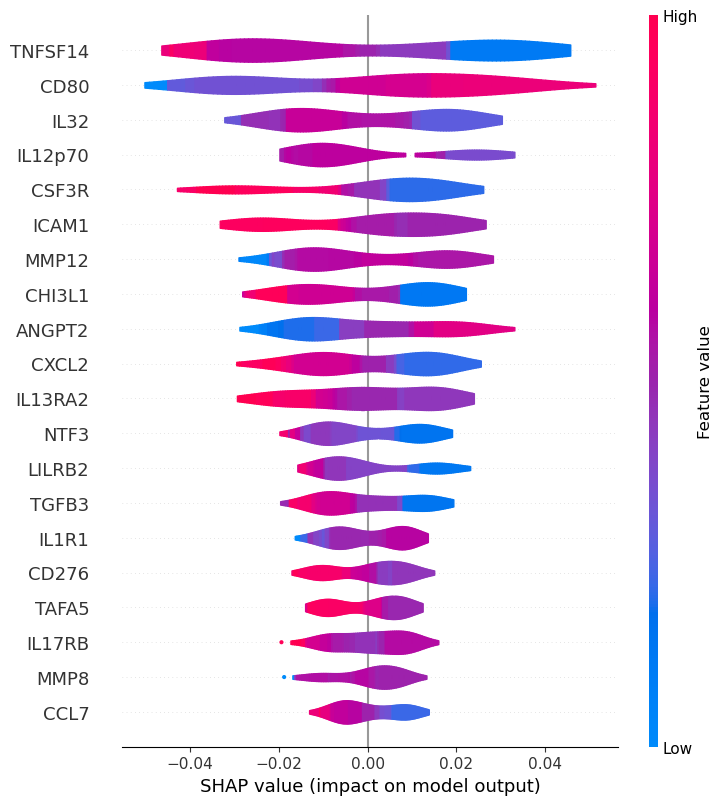

In [37]:
shap.plots.violin(shap_values[:,:,1])

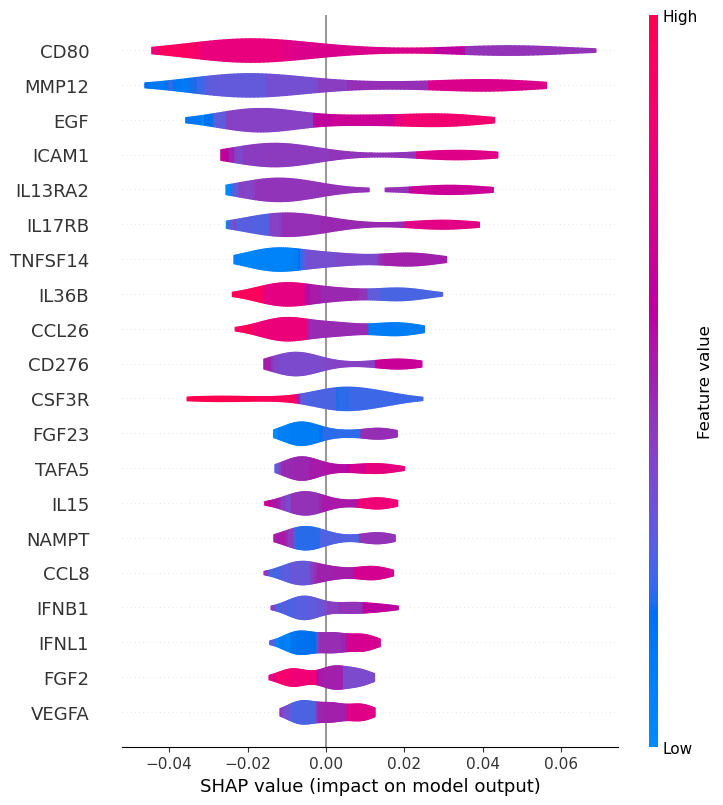

In [38]:
shap.plots.violin(shap_values[:,:,2])

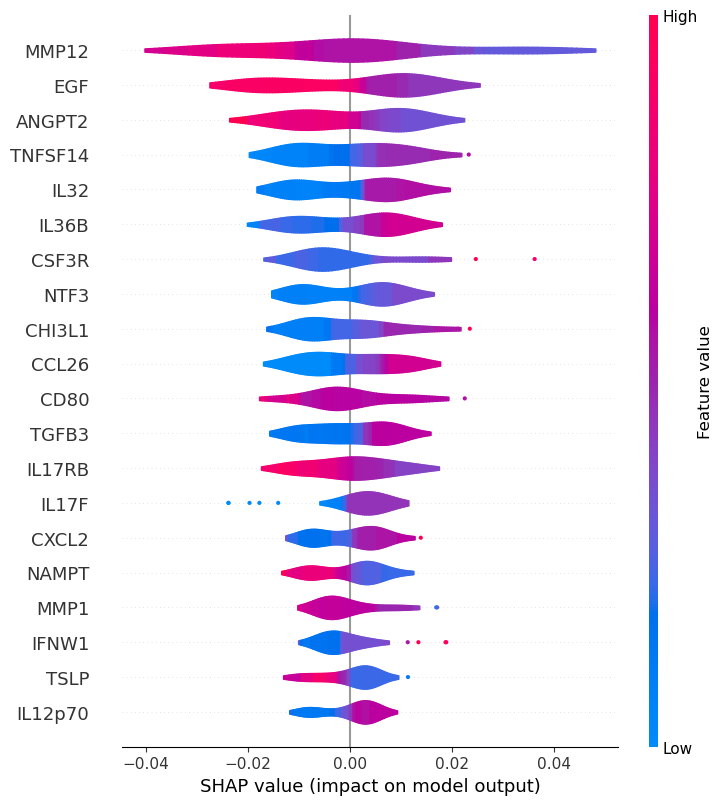

In [39]:
shap.plots.violin(shap_values[:,:,3])

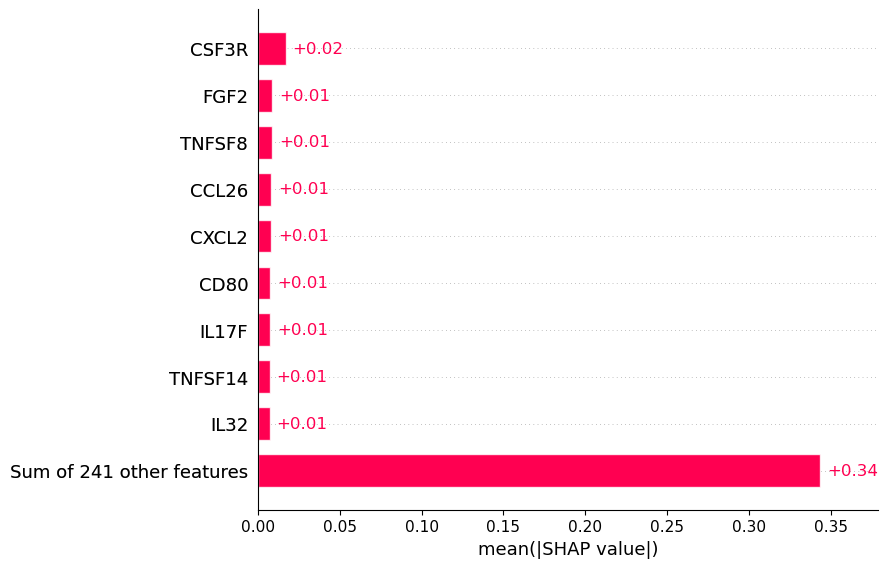

In [40]:
shap.plots.bar(shap_values[:, :, 0])

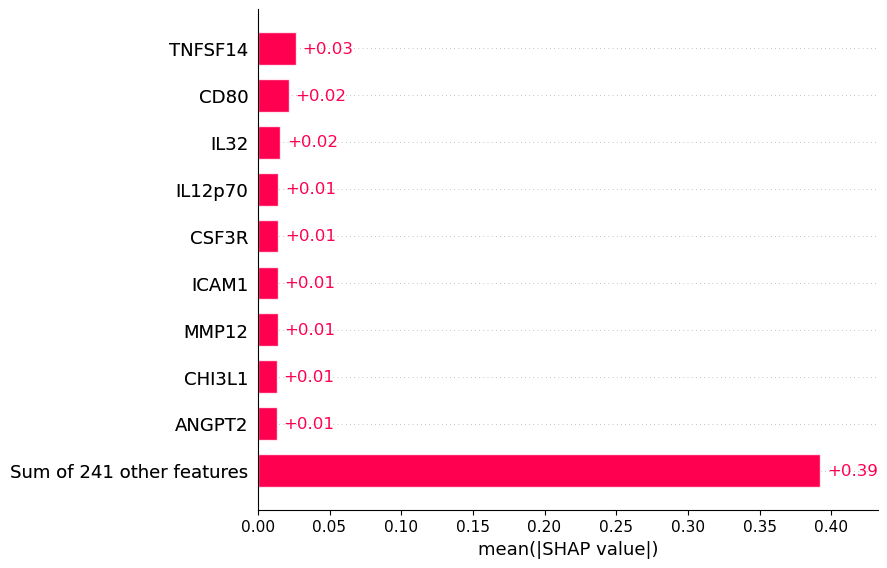

In [41]:
shap.plots.bar(shap_values[:, :, 1])

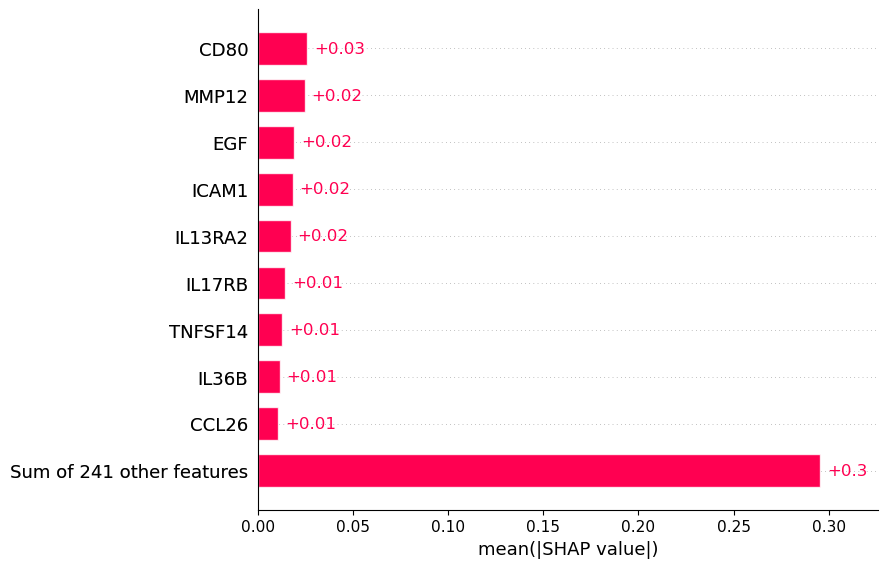

In [42]:
shap.plots.bar(shap_values[:, :, 2])

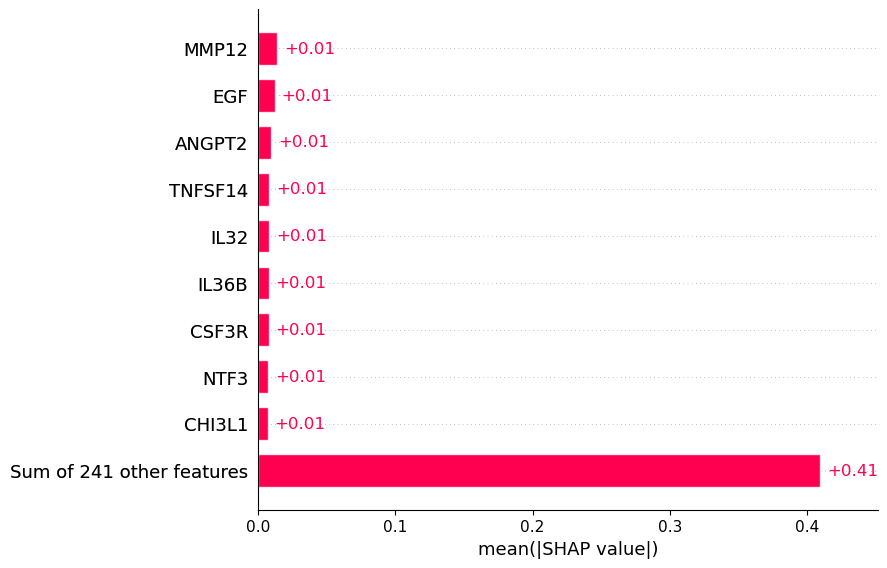

In [43]:
shap.plots.bar(shap_values[:, :, 3])

In [44]:
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

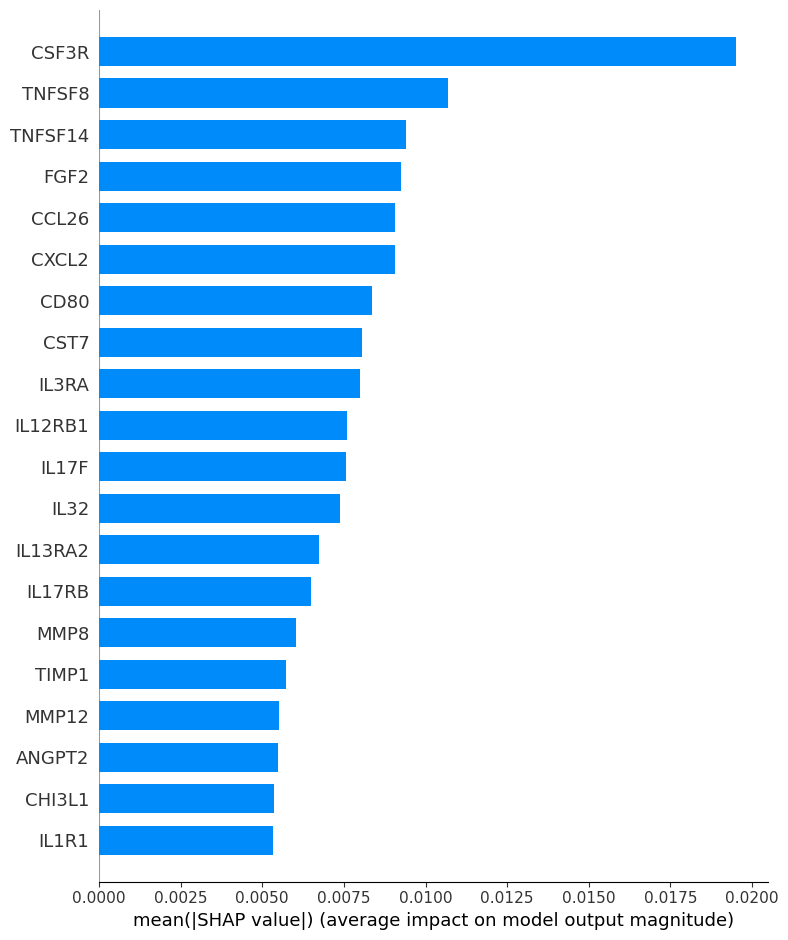

In [45]:
shap.summary_plot(shap_values[:,:,0], X_test.values, plot_type="bar", class_names= class_names, feature_names = X_test.columns)